In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import autograd.numpy as np
from autograd import grad
from autograd.core import primitive
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
from scipy.misc import imread, imresize, imsave
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as spla
import os
import sys
import cv2
import caffe

# Model

In [3]:
# set up
caffe.set_mode_gpu()
caffe.set_device(0)
# load net
net = caffe.Net('models/hough_v6.deploy', 'models/hough_v6.caffemodel', caffe.TEST)

# Hough

In [4]:
H = W = 80

theta_min = -90.
theta_max = 90.
rho_min = np.floor(-np.sqrt(H*H+W*W))
rho_max = np.ceil(np.sqrt(H*H+W*W))

THETA = 360
RHO = 480
theta_step = (theta_max-theta_min) / THETA
rho_step = (rho_max-rho_min) / RHO

sin = lambda x: np.sin(x * np.pi / 180)
cos = lambda x: np.cos(x * np.pi / 180)
sin_ = [sin(x) for x in np.arange(theta_min, theta_max, theta_step)]
cos_ = [cos(x) for x in np.arange(theta_min, theta_max, theta_step)]

val_ = np.zeros(H*W*THETA, dtype=float)
ci_ = np.zeros(H*W*THETA, dtype=int)
ro_ = np.zeros(H*W+1, dtype=int)
for idx in xrange(H*W*THETA):
    hw = idx / THETA
    theta_i = idx % THETA
    h, w = hw/W, hw%W
    ro = hw * THETA
    
    rho = h * sin_[theta_i] + w * cos_[theta_i]
    rho_i = int( (rho-rho_min)/rho_step )
    ci = theta_i * RHO + rho_i
    val_[ro+theta_i] = 1.
    ci_[ro+theta_i] = ci
    
    if theta_i == 0:
        ro_[hw] = ro
        if idx == H*W*THETA-1:
            ro[hw+1] = ro + THETA

hb = csr_matrix((val_, ci_, ro_), shape=(H*W, THETA*RHO), dtype=float)

@primitive
def forward_hough(bottom):
    h, w = bottom.shape
    return hb.transpose().dot(bottom.reshape(-1)).reshape((THETA, RHO))

def backward_hough(top_diff):
    h, w = top_diff.shape
    return hb.dot(top_diff.reshape(-1)).reshape((H, W))

def make_grad_forward_hough(top, bottom):
    return lambda top_diff: backward_hough(top_diff)

forward_hough.defgrad(make_grad_forward_hough)

# nms

In [5]:
def filter_peaks(hftn, sp_theta=8, sp_rho=4, sp_thresh=.8, sp_avg=.4):
    hftn = hftn.copy()
    THETHA, RHO = hftn.shape
    peaks = np.zeros_like(hftn)
    while True:
        idx = np.argmax(hftn)
        theta, rho = idx/RHO, idx%RHO
        theta_min = max(0, int(theta-sp_theta/2))
        theta_max = min(THETA, int(theta+sp_theta/2))
        rho_min = max(0, int(rho-sp_rho/2))
        rho_max = min(RHO, int(rho+sp_rho/2))
        if hftn[theta, rho] < sp_thresh:
            break
        if np.sum(hftn[theta_min:theta_max, rho_min:rho_max]) < sp_avg*sp_theta*sp_rho:
            break
        hftn[theta_min:theta_max, rho_min:rho_max] = 0.
        peaks[theta_min:theta_max, rho_min:rho_max] = 1.
    return peaks

def backpj(hftn):
    r = backward_hough(filter_peaks(hftn))
    if r.max() > 0:
        r /= r.max()
    return r

# Single line

In [7]:
# img = imread('data/misc/fp2.png', mode='RGB')
img = imread('data.old/misc/pos.png', mode='RGB')
in_ = np.array(img, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()
pred_small = imresize(pred, [80, 80]) / 255
hft = forward_hough(pred_small)
hftn = hft / hft.max()

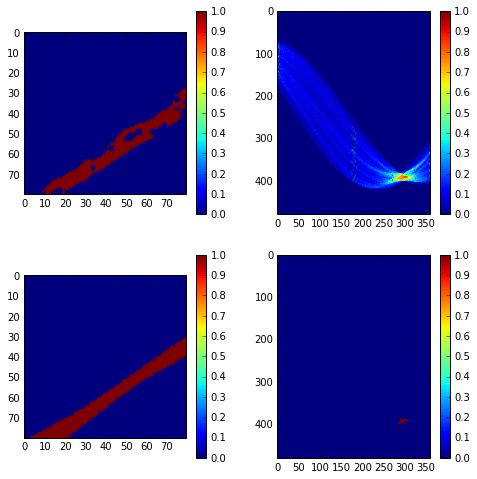

In [10]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(pred_small)
plt.colorbar()
plt.subplot(222)
plt.imshow(hftn.T)
plt.colorbar()
plt.subplot(223)
plt.imshow(backpj(hftn)>.1)
plt.colorbar()
plt.subplot(224)
plt.imshow(filter_peaks(hftn).T)
plt.colorbar()

# Noise

In [11]:
img = imread('data/misc/fp.png', mode='RGB')
in_ = np.array(img, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()
pred_small = imresize(pred, [80, 80]) / 255
hft = forward_hough(pred_small)
if hft.max() > 0:
    hftn = hft / hft.max()
else:
    hftn = hft

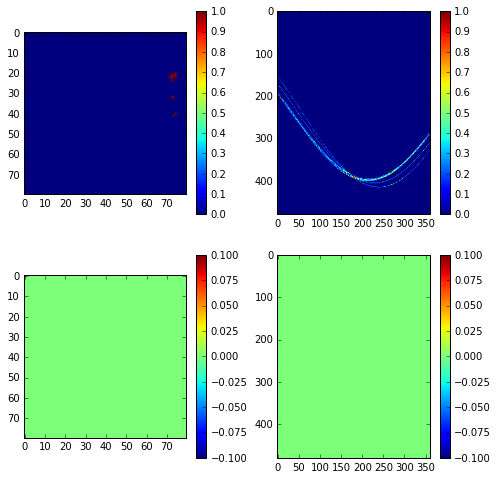

In [12]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(pred_small)
plt.colorbar()
plt.subplot(222)
plt.imshow(hftn.T)
plt.colorbar()
plt.subplot(223)
plt.imshow(backpj(hftn))
plt.colorbar()
plt.subplot(224)
plt.imshow(filter_peaks(hftn).T)
plt.colorbar()

# Multiple line

In [84]:
img = imread('data/train/000362.png', mode='RGB')
lmap = imread('data/train/000362.ppm')
# img = imread('data/train/001210.png', mode='RGB')
# lmap = imread('data/train/001210.ppm')
in_ = np.array(img, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
pred = net.blobs['sigmoid-fuse'].data[0][0,:,:].copy()
pred_small = imresize(pred, [80, 80]) / 255
lmap_small = imresize(lmap, [80, 80]) / 255
hft = forward_hough(pred_small)
hftn = hft / hft.max()

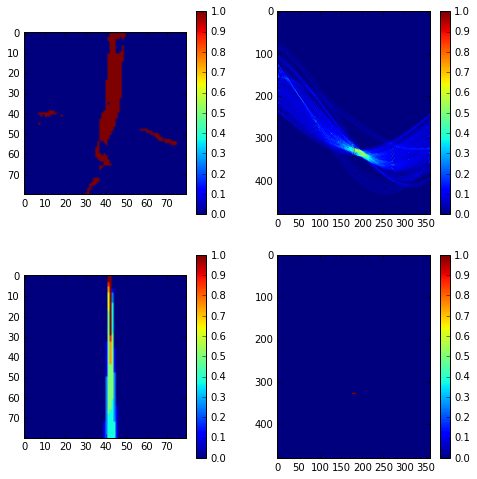

In [85]:
plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.imshow(pred_small)
plt.colorbar()
plt.subplot(222)
plt.imshow(hftn.T)
plt.colorbar()
plt.subplot(223)
plt.imshow(backpj(hftn))
plt.colorbar()
plt.subplot(224)
plt.imshow(filter_peaks(hftn).T)
plt.colorbar()

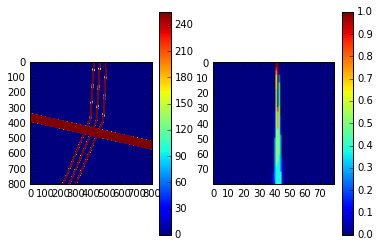

In [87]:
plt.subplot(121)
plt.imshow(lmap)
plt.colorbar()
plt.subplot(122)
plt.imshow(backpj(hftn))
plt.colorbar()